In [1]:
import time
import numpy as np
np.random.seed(1)
import pandas as pd
import json
import matplotlib.pyplot as plt

In [2]:
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

In [35]:
bucket = 'synthetic-data-demo'
prefix = 'sagemaker/DEMO-deepar'

sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

In [4]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

In [5]:
freq = 'H'
prediction_length = 48

In [6]:
context_length = 72


In [7]:
t0 = '2004-01-02 00:00:00'
data_length = 400
num_ts = 200
period = 24

In [8]:
time_series = []
for k in range(num_ts):
    level = 10 * np.random.rand()
    seas_amplitude = (0.1 + 0.3*np.random.rand()) * level
    sig = 0.05 * level # noise parameter (constant in time)
    time_ticks = np.array(range(data_length))
    source = level + seas_amplitude*np.sin(time_ticks*(2*np.pi)/period)
    noise = sig*np.random.randn(data_length)
    data = source + noise
    index = pd.DatetimeIndex(start=t0, freq=freq, periods=data_length)
    time_series.append(pd.Series(data=data, index=index))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


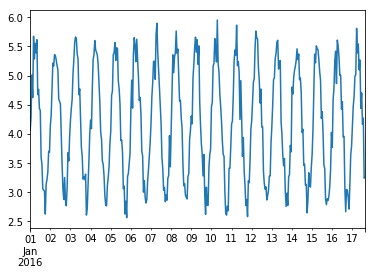

In [9]:
time_series[0].plot()
plt.show()

In [10]:
time_series_training = []
for ts in time_series:
    time_series_training.append(ts[:-prediction_length])

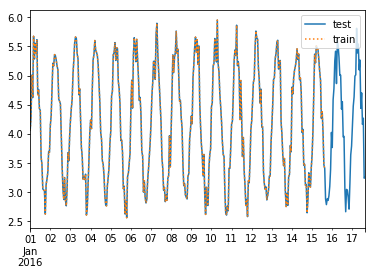

In [11]:
time_series[0].plot(label='test')
time_series_training[0].plot(label='train', ls=':')
plt.legend()
plt.show()

In [12]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [14]:
encoding = "utf-8"
s3filesystem = s3fs.S3FileSystem()

with s3filesystem.open(s3_data_path + "/train/train.json", 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

with s3filesystem.open(s3_data_path + "/test/test.json", 'wb') as fp:
    for ts in time_series:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

In [15]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='DEMO-deepar',
    output_path="s3://" + s3_output_path
)

In [16]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [17]:
estimator.set_hyperparameters(**hyperparameters)


In [18]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

2020-06-14 23:46:59 Starting - Starting the training job...
2020-06-14 23:47:02 Starting - Launching requested ML instances......
2020-06-14 23:48:15 Starting - Preparing the instances for training...
2020-06-14 23:48:56 Downloading - Downloading input data...
2020-06-14 23:49:03 Training - Downloading the training image...
2020-06-14 23:49:47 Training - Training image download completed. Training in progress.Arguments: train
[06/14/2020 23:49:50 INFO 139734996457280] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'au

[06/14/2020 23:49:57 INFO 139734996457280] Epoch[3] Batch[5] avg_epoch_loss=0.120363
[06/14/2020 23:49:57 INFO 139734996457280] #quality_metric: host=algo-1, epoch=3, batch=5 train loss <loss>=0.120363046726
[06/14/2020 23:49:57 INFO 139734996457280] Epoch[3] Batch [5]#011Speed: 244.91 samples/sec#011loss=0.120363
[06/14/2020 23:49:57 INFO 139734996457280] Epoch[3] Batch[10] avg_epoch_loss=0.099317
[06/14/2020 23:49:57 INFO 139734996457280] #quality_metric: host=algo-1, epoch=3, batch=10 train loss <loss>=0.0740613073111
[06/14/2020 23:49:57 INFO 139734996457280] Epoch[3] Batch [10]#011Speed: 226.25 samples/sec#011loss=0.074061
[06/14/2020 23:49:57 INFO 139734996457280] processed a total of 339 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1576.9639015197754, "sum": 1576.9639015197754, "min": 1576.9639015197754}}, "EndTime": 1592178597.944069, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1592178596.367037}

[06/1

[06/14/2020 23:50:06 INFO 139734996457280] Epoch[9] Batch[5] avg_epoch_loss=-0.079670
[06/14/2020 23:50:06 INFO 139734996457280] #quality_metric: host=algo-1, epoch=9, batch=5 train loss <loss>=-0.0796699858426
[06/14/2020 23:50:06 INFO 139734996457280] Epoch[9] Batch [5]#011Speed: 243.19 samples/sec#011loss=-0.079670
[06/14/2020 23:50:07 INFO 139734996457280] processed a total of 318 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1428.5569190979004, "sum": 1428.5569190979004, "min": 1428.5569190979004}}, "EndTime": 1592178607.470976, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1592178606.042354}

[06/14/2020 23:50:07 INFO 139734996457280] #throughput_metric: host=algo-1, train throughput=222.580418164 records/second
[06/14/2020 23:50:07 INFO 139734996457280] #progress_metric: host=algo-1, completed 50 % of epochs
[06/14/2020 23:50:07 INFO 139734996457280] #quality_metric: host=algo-1, epoch=9, train loss <loss>=

[06/14/2020 23:50:16 INFO 139734996457280] Epoch[15] Batch[10] avg_epoch_loss=-0.154598
[06/14/2020 23:50:16 INFO 139734996457280] #quality_metric: host=algo-1, epoch=15, batch=10 train loss <loss>=-0.275213198364
[06/14/2020 23:50:16 INFO 139734996457280] Epoch[15] Batch [10]#011Speed: 237.74 samples/sec#011loss=-0.275213
[06/14/2020 23:50:16 INFO 139734996457280] processed a total of 348 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1584.8281383514404, "sum": 1584.8281383514404, "min": 1584.8281383514404}}, "EndTime": 1592178616.716841, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1592178615.13153}

[06/14/2020 23:50:16 INFO 139734996457280] #throughput_metric: host=algo-1, train throughput=219.56720576 records/second
[06/14/2020 23:50:16 INFO 139734996457280] #progress_metric: host=algo-1, completed 80 % of epochs
[06/14/2020 23:50:16 INFO 139734996457280] #quality_metric: host=algo-1, epoch=15, train loss <lo

#metrics {"Metrics": {"model.score.time": {"count": 1, "max": 14160.701036453247, "sum": 14160.701036453247, "min": 14160.701036453247}}, "EndTime": 1592178637.829081, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1592178623.668485}

[06/14/2020 23:50:37 INFO 139734996457280] #test_score (algo-1, RMSE): 0.356192926525
[06/14/2020 23:50:37 INFO 139734996457280] #test_score (algo-1, mean_absolute_QuantileLoss): 1801.3131082273399
[06/14/2020 23:50:37 INFO 139734996457280] #test_score (algo-1, mean_wQuantileLoss): 0.038350624610937106
[06/14/2020 23:50:37 INFO 139734996457280] #test_score (algo-1, wQuantileLoss[0.1]): 0.022798739703276137
[06/14/2020 23:50:37 INFO 139734996457280] #test_score (algo-1, wQuantileLoss[0.2]): 0.036000519133877175
[06/14/2020 23:50:37 INFO 139734996457280] #test_score (algo-1, wQuantileLoss[0.3]): 0.04419561937700262
[06/14/2020 23:50:37 INFO 139734996457280] #test_score (algo-1, wQuantileLoss[0.4]): 0.04876

In [19]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

-------------!

In [20]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [21]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)


In [38]:
x = time_series_training[0]
x.index[-1]+1

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  from ipykernel import kernelapp as app


Timestamp('2016-01-15 16:00:00', freq='H')

In [33]:
x

2016-01-01 00:00:00    4.060090
2016-01-01 01:00:00    4.287668
2016-01-01 02:00:00    5.009765
2016-01-01 03:00:00    4.622429
2016-01-01 04:00:00    5.675623
2016-01-01 05:00:00    5.284779
2016-01-01 06:00:00    5.554939
2016-01-01 07:00:00    5.391503
2016-01-01 08:00:00    5.616676
2016-01-01 09:00:00    4.672763
2016-01-01 10:00:00    4.762090
2016-01-01 11:00:00    4.431315
2016-01-01 12:00:00    4.406623
2016-01-01 13:00:00    3.599707
2016-01-01 14:00:00    3.475169
2016-01-01 15:00:00    3.055072
2016-01-01 16:00:00    3.037431
2016-01-01 17:00:00    3.018464
2016-01-01 18:00:00    2.622533
2016-01-01 19:00:00    3.135628
2016-01-01 20:00:00    3.216621
2016-01-01 21:00:00    3.342891
2016-01-01 22:00:00    3.698961
2016-01-01 23:00:00    3.686481
2016-01-02 00:00:00    4.144596
2016-01-02 01:00:00    4.316276
2016-01-02 02:00:00    4.773460
2016-01-02 03:00:00    5.212910
2016-01-02 04:00:00    5.167592
2016-01-02 05:00:00    5.360772
                         ...   
2016-01-

In [31]:
a = time_series_training[:5]

In [32]:
a

[2016-01-01 00:00:00    4.060090
 2016-01-01 01:00:00    4.287668
 2016-01-01 02:00:00    5.009765
 2016-01-01 03:00:00    4.622429
 2016-01-01 04:00:00    5.675623
 2016-01-01 05:00:00    5.284779
 2016-01-01 06:00:00    5.554939
 2016-01-01 07:00:00    5.391503
 2016-01-01 08:00:00    5.616676
 2016-01-01 09:00:00    4.672763
 2016-01-01 10:00:00    4.762090
 2016-01-01 11:00:00    4.431315
 2016-01-01 12:00:00    4.406623
 2016-01-01 13:00:00    3.599707
 2016-01-01 14:00:00    3.475169
 2016-01-01 15:00:00    3.055072
 2016-01-01 16:00:00    3.037431
 2016-01-01 17:00:00    3.018464
 2016-01-01 18:00:00    2.622533
 2016-01-01 19:00:00    3.135628
 2016-01-01 20:00:00    3.216621
 2016-01-01 21:00:00    3.342891
 2016-01-01 22:00:00    3.698961
 2016-01-01 23:00:00    3.686481
 2016-01-02 00:00:00    4.144596
 2016-01-02 01:00:00    4.316276
 2016-01-02 02:00:00    4.773460
 2016-01-02 03:00:00    5.212910
 2016-01-02 04:00:00    5.167592
 2016-01-02 05:00:00    5.360772
          

In [39]:
time_series_training[:5]

[2016-01-01 00:00:00    4.060090
 2016-01-01 01:00:00    4.287668
 2016-01-01 02:00:00    5.009765
 2016-01-01 03:00:00    4.622429
 2016-01-01 04:00:00    5.675623
 2016-01-01 05:00:00    5.284779
 2016-01-01 06:00:00    5.554939
 2016-01-01 07:00:00    5.391503
 2016-01-01 08:00:00    5.616676
 2016-01-01 09:00:00    4.672763
 2016-01-01 10:00:00    4.762090
 2016-01-01 11:00:00    4.431315
 2016-01-01 12:00:00    4.406623
 2016-01-01 13:00:00    3.599707
 2016-01-01 14:00:00    3.475169
 2016-01-01 15:00:00    3.055072
 2016-01-01 16:00:00    3.037431
 2016-01-01 17:00:00    3.018464
 2016-01-01 18:00:00    2.622533
 2016-01-01 19:00:00    3.135628
 2016-01-01 20:00:00    3.216621
 2016-01-01 21:00:00    3.342891
 2016-01-01 22:00:00    3.698961
 2016-01-01 23:00:00    3.686481
 2016-01-02 00:00:00    4.144596
 2016-01-02 01:00:00    4.316276
 2016-01-02 02:00:00    4.773460
 2016-01-02 03:00:00    5.212910
 2016-01-02 04:00:00    5.167592
 2016-01-02 05:00:00    5.360772
          

In [28]:
list_of_df = predictor.predict(time_series_training[:5])
actual_data = time_series[:5]

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:29: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:44: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


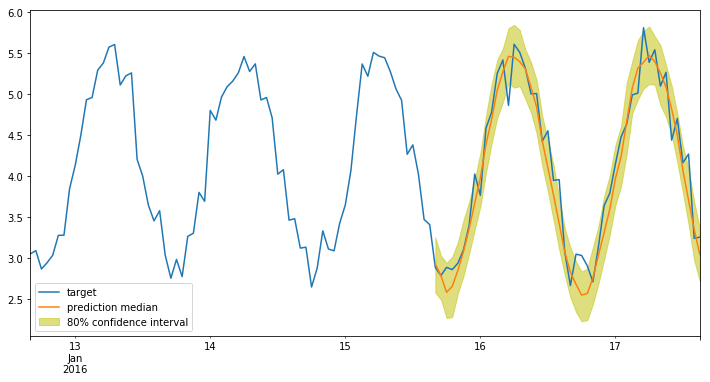

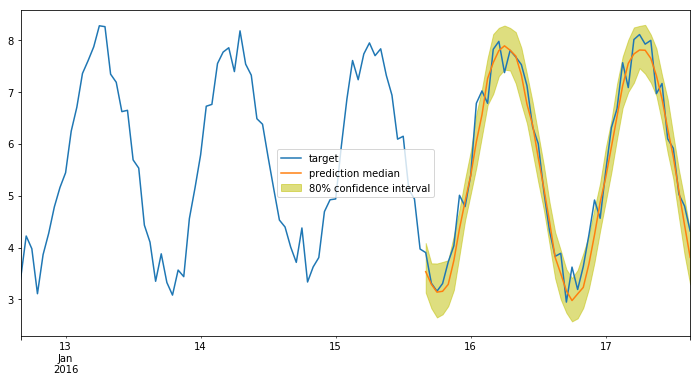

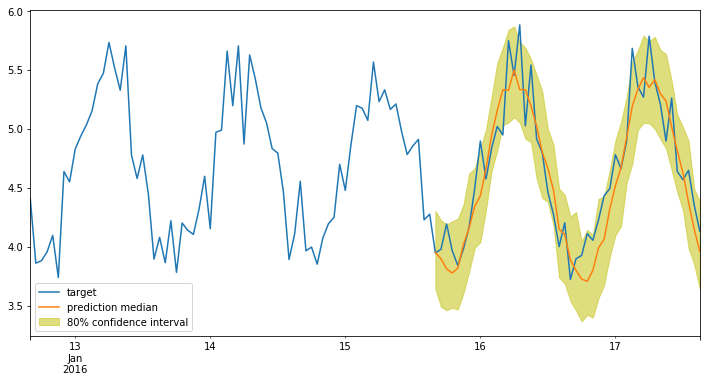

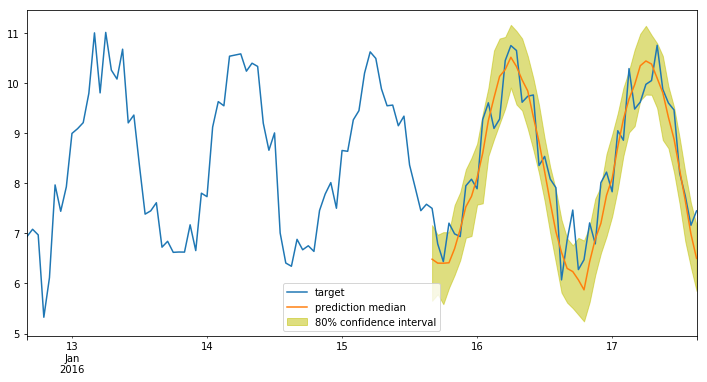

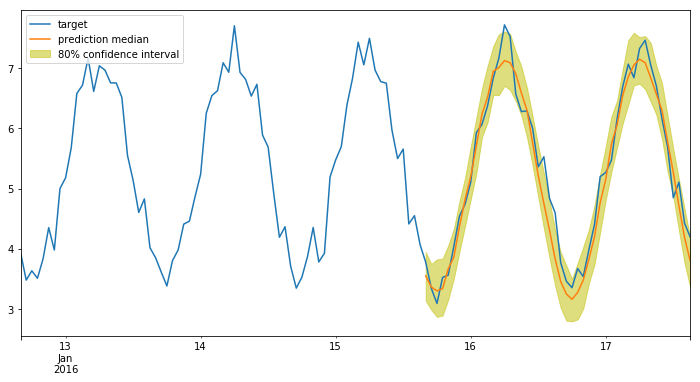

In [29]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()